# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

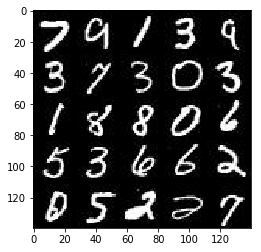

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

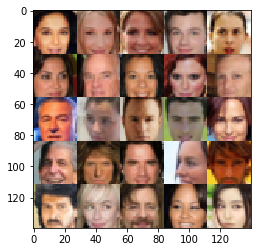

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        lay1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        lay1 = tf.maximum(alpha * lay1, lay1)
        
        lay2 = tf.layers.conv2d(lay1, 128, 5, 2, 'same')
        lay2 = tf.layers.batch_normalization(lay2, training=True)
        lay2 = tf.maximum(alpha * lay2, lay2)
        
        lay3 = tf.layers.conv2d(lay2, 256, 5, 2, 'same')
        lay3 = tf.layers.batch_normalization(lay3, training=True)
        lay3 = tf.maximum(alpha * lay3, lay3)

        flat = tf.reshape(lay3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        lay1 = tf.layers.dense(z, 2*2*512)
        lay1 = tf.reshape(lay1, (-1, 2, 2, 512))
        lay1 = tf.layers.batch_normalization(lay1, training=is_train)
        lay1 = tf.maximum(alpha * lay1, lay1)
    
        lay2 = tf.layers.conv2d_transpose(lay1, 256, 5, 2, 'valid')
        lay2 = tf.layers.batch_normalization(lay2, training=is_train)
        lay2 = tf.maximum(alpha * lay2, lay2)
    
        lay3 = tf.layers.conv2d_transpose(lay2, 128, 5, 2, 'same')
        lay3 = tf.layers.batch_normalization(lay3, training=is_train)
        lay3 = tf.maximum(alpha * lay3, lay3)
    
        logits = tf.layers.conv2d_transpose(lay3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    n_images = 25
    print_every = 15
    show_every = 100
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8243... Generator Loss: 0.1697
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 2.5508
Epoch 1/2... Discriminator Loss: 0.3271... Generator Loss: 1.9421
Epoch 1/2... Discriminator Loss: 0.0298... Generator Loss: 12.0704
Epoch 1/2... Discriminator Loss: 0.0544... Generator Loss: 3.8388
Epoch 1/2... Discriminator Loss: 0.1506... Generator Loss: 2.3749


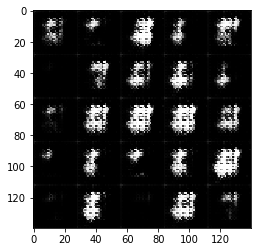

Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 6.7368
Epoch 1/2... Discriminator Loss: 2.7900... Generator Loss: 0.2346
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 4.5565
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.8380
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 3.8334
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.5436


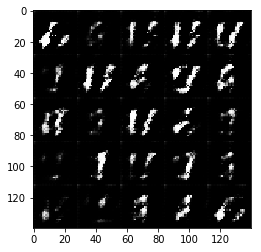

Epoch 1/2... Discriminator Loss: 2.3467... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 0.3222... Generator Loss: 1.8566
Epoch 1/2... Discriminator Loss: 2.2651... Generator Loss: 5.9733
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.5919


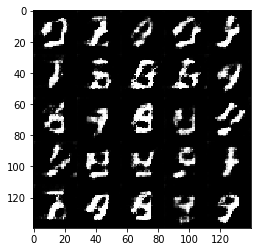

Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.3832
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 1.8522
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 2.9221
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.3031
Epoch 1/2... Discriminator Loss: 1.5457... Generator Loss: 0.3595


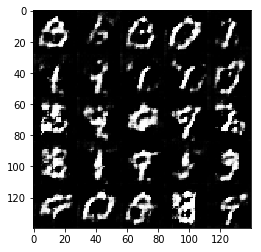

Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.0379
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.8347
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 1.3275
Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 1.7859
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6009
Epoch 1/2... Discriminator Loss: 1.8202... Generator Loss: 0.2505


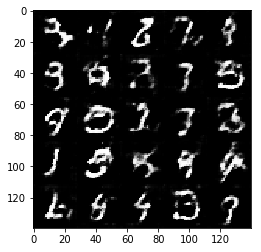

Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.2450
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.0624... Generator Loss: 0.8420


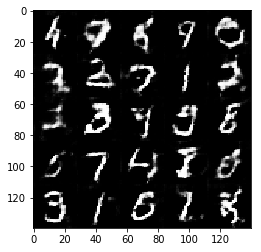

Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 0.9489... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 1.6148
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 1.3120
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 1.4302


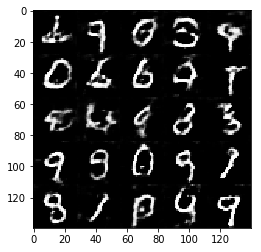

Epoch 1/2... Discriminator Loss: 1.8382... Generator Loss: 0.2425
Epoch 1/2... Discriminator Loss: 1.3456... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 1.6510
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 0.9072... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 1.2596


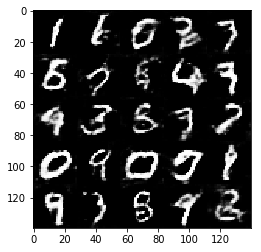

Epoch 1/2... Discriminator Loss: 1.7888... Generator Loss: 3.0512
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.4088
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.5965


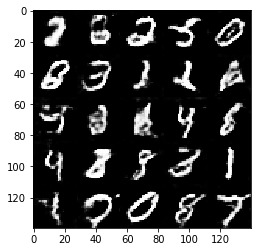

Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.6176
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.3843
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.8758
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.7394


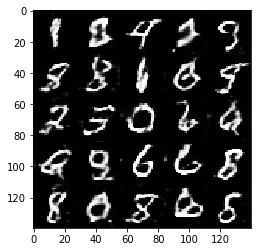

Epoch 2/2... Discriminator Loss: 1.5772... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 1.8378... Generator Loss: 0.2211
Epoch 2/2... Discriminator Loss: 1.4555... Generator Loss: 0.4215
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 1.0053
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.3899


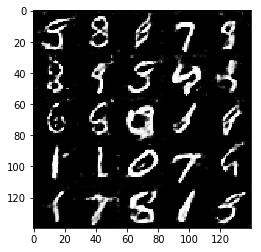

Epoch 2/2... Discriminator Loss: 1.8122... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.4735
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.4724
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.3929


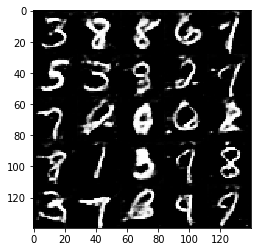

Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 2.2951
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.6266
Epoch 2/2... Discriminator Loss: 1.6314... Generator Loss: 0.3131
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.3675


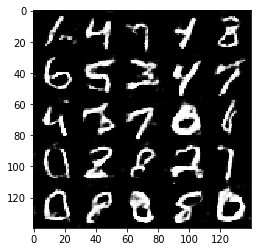

Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.4971
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 1.8902
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.9381


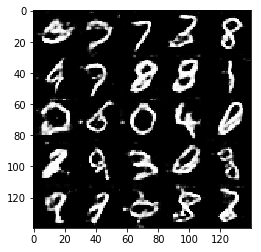

Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 2.3035
Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 2.2032
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.0141


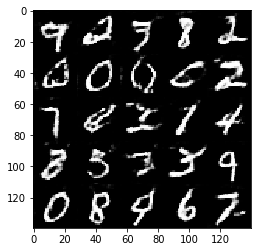

Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.2658
Epoch 2/2... Discriminator Loss: 2.1546... Generator Loss: 3.2612
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 1.1391
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 1.7867


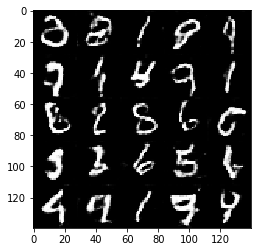

Epoch 2/2... Discriminator Loss: 1.7828... Generator Loss: 0.3204
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 1.8375
Epoch 2/2... Discriminator Loss: 2.0023... Generator Loss: 0.2540
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 1.9113


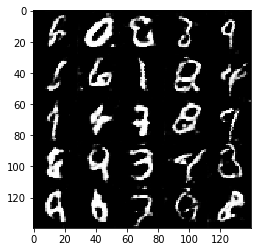

Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.7125... Generator Loss: 0.3221
Epoch 2/2... Discriminator Loss: 1.0920... Generator Loss: 0.6409


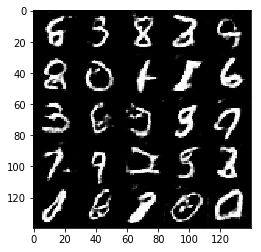

Epoch 2/2... Discriminator Loss: 1.5263... Generator Loss: 4.0053
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 2.3367
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 1.5565
Epoch 2/2... Discriminator Loss: 1.0172... Generator Loss: 0.8323


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6574... Generator Loss: 0.0454
Epoch 1/1... Discriminator Loss: 0.3054... Generator Loss: 2.1817
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 3.3494... Generator Loss: 7.2323
Epoch 1/1... Discriminator Loss: 0.5040... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.3199


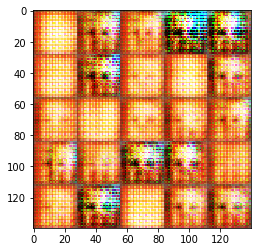

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 2.7634
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 2.2784
Epoch 1/1... Discriminator Loss: 0.2293... Generator Loss: 3.5796
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.5354
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 2.9804


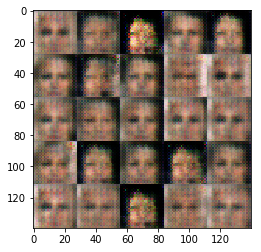

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 3.0805
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.2584
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.9441
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 0.8474


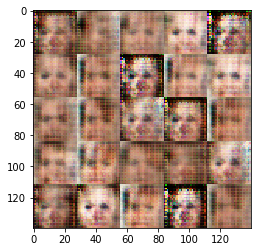

Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 1.5636
Epoch 1/1... Discriminator Loss: 2.5916... Generator Loss: 0.0992
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.1740


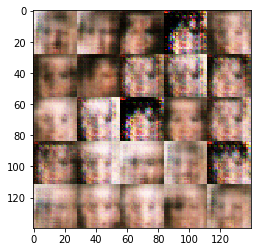

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 1.5249


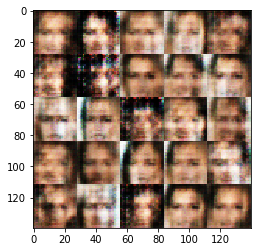

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.9196... Generator Loss: 2.0176
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 1.9394


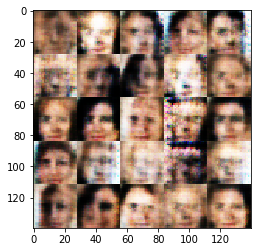

Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 1.3907


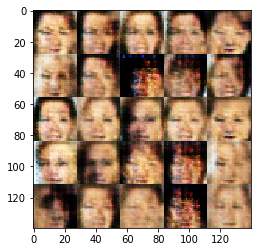

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 2.4489... Generator Loss: 3.1915
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.3559


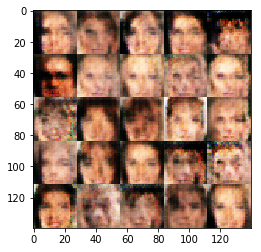

Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.1583


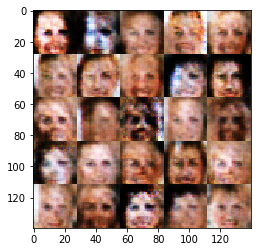

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.8890... Generator Loss: 0.2876
Epoch 1/1... Discriminator Loss: 1.8903... Generator Loss: 0.2180


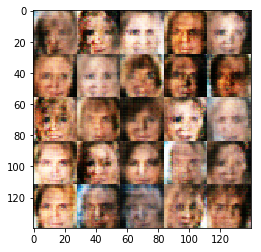

Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8491


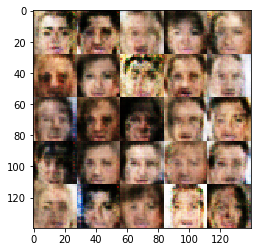

Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9819


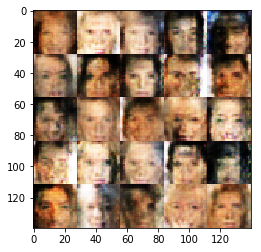

Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.3274


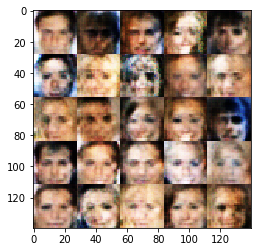

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.7863


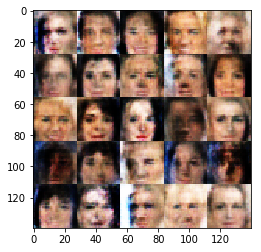

Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.3418
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6645


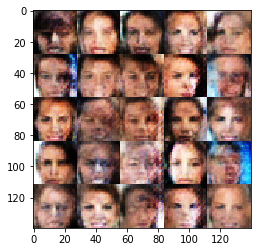

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.8361... Generator Loss: 2.0542
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.1661


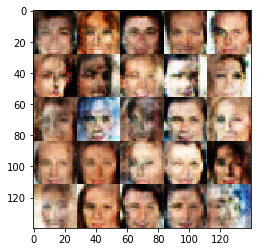

Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7491


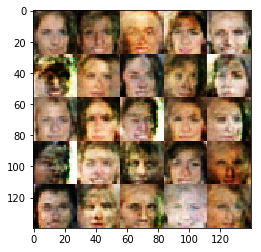

Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.5109


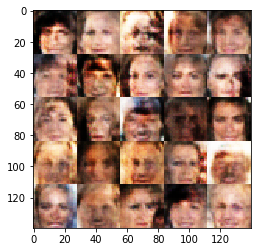

Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.1675


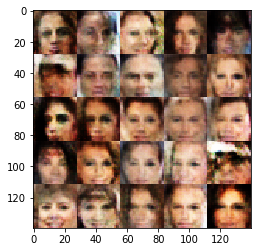

Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 1.5696
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 1.0902


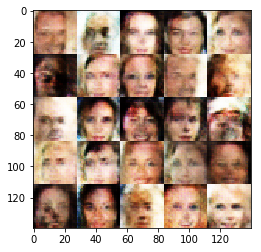

Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.3421
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6312


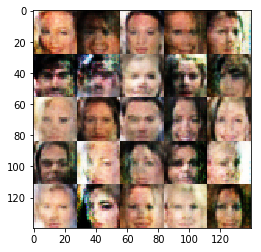

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 0.2790
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.3997


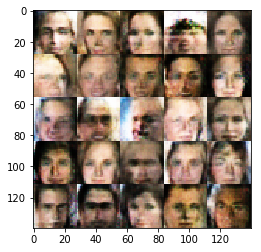

Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 1.3038


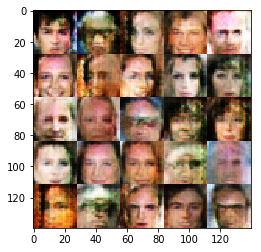

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.6207


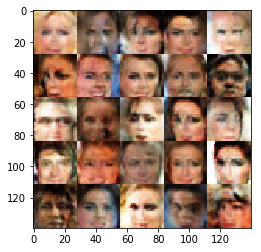

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8056


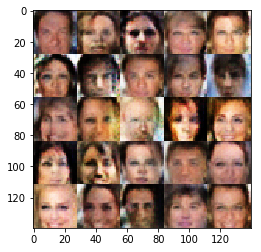

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.0172


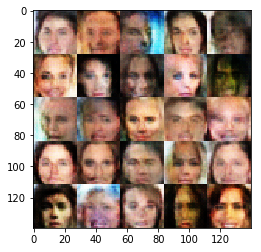

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.3078


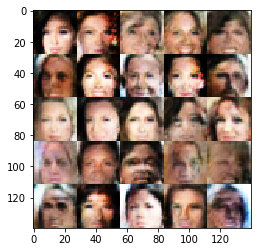

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.2471
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.6236


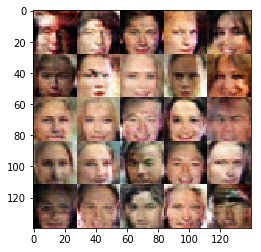

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.1608


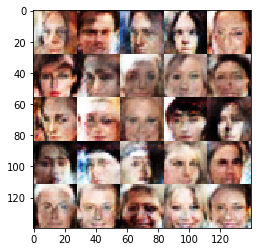

Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.6083... Generator Loss: 1.7631
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.7654


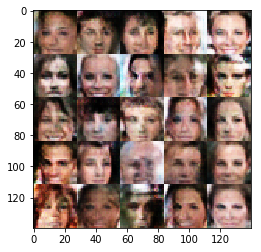

Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.8697


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.